# 🧱 DCGAN - Bricks データ

本ノートブックでは，レンガのデータセットを使ってDCGANを学習します．

In [7]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
import torchvision
import torch
import torchinfo
import random
import json
import pandas as pd
import kagglehub
from torch import nn
from torch.utils.data import DataLoader, Subset
import sys
print(sys.version)
print(torch.__version__)
print(torchvision.__version__)

3.11.10 (main, Oct 19 2024, 01:02:19) [GCC 10.2.1 20210110]
2.1.0+cu121
0.16.0+cu121


In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# シード値を設定
set_seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cpu


## 0. パラメータ

In [9]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. データの準備

In [10]:
# kakgglehubを使ってダウンロード -> pathに保存
dataset_path = kagglehub.dataset_download("joosthazelzet/lego-brick-images")

print("Path to dataset files:", dataset_path)

Path to dataset files: /root/.cache/kagglehub/datasets/joosthazelzet/lego-brick-images/versions/4


In [11]:
# データ変換の定義
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5]),
])
# カスタムImageFolderの定義 
class CustomImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform, target_transform=target_transform)

    def __getitem__(self, index):
        # 画像とラベルを取得
        path, _ = self.samples[index]
        image = self.loader(path)
        if self.transform is not None:
            image = self.transform(image)
        
        # 属性を取得
        filename = os.path.basename(path)

        return image, filename

# 通常どおりデータセットを読み込む
full_dataset = CustomImageFolder(root=dataset_path, transform=transform)

# 取得したいクラス（ディレクトリ）をリストで指定
desired_classes = ['dataset']

# クラスのインデックスを取得し、学習に使うデータをフィルタ
desired_class_indices = [full_dataset.class_to_idx[cls_name] for cls_name in desired_classes]
full_dataset.samples = [(path, class_idx) for path, class_idx in full_dataset.samples if class_idx in desired_class_indices]

# データセットのサブセット(訓練用/テスト用)を作成
validation_txt_path = os.path.join(dataset_path, 'validation.txt')

# 1. validation.txt を読み込み、検証用ファイル名のセットを作成
validation_files = set()
with open(validation_txt_path, 'r') as f:
    for line in f:
        # 行を分割してファイル名を取得（必要に応じて調整）
        filename = line.strip()

        validation_files.add(filename)

# 2. ファイル名に基づいてデータセットを分割
file_to_partition = {}
for _path, _ in full_dataset.samples:
    filename = os.path.basename(_path)
    if filename in validation_files:
        file_to_partition[filename] = 2  # テストセット
    else:
        file_to_partition[filename] = 0  # トレーニングセット

# インデックスを取得
train_indices = [i for i, (_path, _) in enumerate(full_dataset.samples) if file_to_partition[os.path.basename(_path)] == 0]
test_indices = [i for i, (_path, _) in enumerate(full_dataset.samples) if file_to_partition[os.path.basename(_path)] == 2]

# サブセットを作成
trainset = Subset(full_dataset, train_indices)
# 学習時間が長いので学習データを絞る（本書の実装にはない）
# フルデータで学習したい場合は以下をコメントアウトしてください．
# print("full train dataset len", len(trainset))
# data_ratio = 0.5
# subset_indices = random.sample(range(len(trainset)), int(data_ratio * len(trainset)))  # データの50%
# trainset = Subset(trainset, subset_indices)
# print("trainset len", len(trainset))
####
testset = Subset(full_dataset, test_indices)

# データローダーを作成
trainloader = DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)

testloader = DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

(1, 64, 64)
特徴一覧：
 14719 flat tile corner 2x2 080R.png


<function matplotlib.pyplot.show(close=None, block=None)>

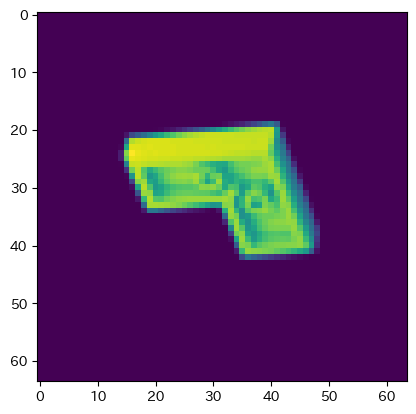

In [12]:
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
print("特徴一覧：\n",trainset[1][1])
plt.imshow(trainset[1][0].permute(1, 2, 0)*0.5 + 0.5)
plt.show

## 2. DCGANを構築

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=64, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 64 -> 32
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 32 -> 16
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 16 -> 8
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 8 -> 4
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=(4, 4), stride=1, padding=0, bias=False) # 4 -> 1

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.3)
        self.batch_norm1 = nn.BatchNorm2d(num_features=128, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.batch_norm2 = nn.BatchNorm2d(num_features=256, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.batch_norm3 = nn.BatchNorm2d(num_features=512, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.conv5(x)
        x = self.sigmoid(x)
        x = self.flatten(x)
        
        return x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.deconv1 = nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=(4, 4), stride=1, padding=0, bias=False) # 1 -> 4
        self.deconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 4 -> 8
        self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 8 -> 16
        self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 16 -> 32
        self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=CHANNELS, kernel_size=(4, 4), stride=2, padding=1, bias=False) # 32 -> 64

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        self.batch_norm1 = nn.BatchNorm2d(num_features=512, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.batch_norm2 = nn.BatchNorm2d(num_features=256, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.batch_norm3 = nn.BatchNorm2d(num_features=128, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.batch_norm4 = nn.BatchNorm2d(num_features=64, momentum=0.1) # 注： tfとmomentumの定義が異なる(torch 2.1.0+cu121)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), Z_DIM, 1, 1)
        x = self.deconv1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)
        x = self.deconv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)
        x = self.deconv3(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu(x)
        x = self.deconv4(x)
        x = self.batch_norm4(x)
        x = self.leaky_relu(x)
        x = self.deconv5(x)
        x = self.tanh(x)
        
        return x


class DCGAN(nn.Module):
    def __init__(self, latent_dim, noise_param, device):
        super().__init__()
        self.D = Discriminator()
        self.G = Generator()
        self.latent_dim = latent_dim
        self.loss_fn = nn.BCELoss()
        self.NOISE_PARAM = noise_param # ラベルノイズのパラメータ
        self.device = device
        self.d_opt = torch.optim.Adam(self.D.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.g_opt = torch.optim.Adam(self.G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    def train_one_step(self, real_images):
        # 潜在空間内のランダムな点をサンプルする
        batch_size = real_images.size(0)
        random_latent_vectors = torch.randn(size=(batch_size, self.latent_dim), device=self.device)
        
        # -------------------------
        # 識別器Dの学習
        # -------------------------
        self.D.train()
        self.d_opt.zero_grad()

        # 生成器から偽画像を生成（学習しないので勾配は計算しない）
        with torch.no_grad():
            generated_images = self.G(random_latent_vectors)
        
        # Discriminatorの予測
        real_predictions = self.D(real_images)
        fake_predictions = self.D(generated_images)

        # ラベルとノイズの追加
        real_labels = torch.ones_like(real_predictions, device=self.device)
        fake_labels = torch.zeros_like(fake_predictions, device=self.device)
        # 参考）rand_likeは[0, 1)の一様分布でサンプル．足されているノイズの符号は多分誤植なので以下では入れ替えている．
        real_noisy_labels = real_labels - self.NOISE_PARAM * torch.rand_like(real_predictions)
        fake_noisy_labels = fake_labels + self.NOISE_PARAM * torch.rand_like(fake_predictions)

        # 損失計算
        d_real_loss = self.loss_fn(real_predictions, real_noisy_labels)
        d_fake_loss = self.loss_fn(fake_predictions, fake_noisy_labels)

        d_loss = (d_real_loss + d_fake_loss) / 2.0

        d_loss.backward()
        self.d_opt.step()

        # 精度の計算
        d_real_acc = (real_predictions >= 0.5).float().mean()
        d_fake_acc = (fake_predictions < 0.5).float().mean()
        d_acc = (d_real_acc + d_fake_acc) / 2.0

        # ----------------------
        # 生成器Gのトレーニング
        # ----------------------
        self.G.train()
        self.g_opt.zero_grad()

        # 生成器から偽画像を生成
        generated_images = self.G(random_latent_vectors)
        fake_predictions = self.D(generated_images) # 以下ではg_optimzerを使うのでパラメータは更新されない

        # ラベルは全て1(生成器は識別器を騙したいので)
        real_labels = torch.ones_like(fake_predictions, device=self.device)
        g_loss = self.loss_fn(fake_predictions, real_labels)

        g_loss.backward()
        self.g_opt.step()

        # 精度の計算
        g_acc = (fake_predictions >= 0.5).float().mean()

        # メトリクスの記録
        metrics = {
            "d_loss" : d_loss.item(),
            "d_real_acc" : d_real_acc.item(),
            "d_fake_acc" : d_fake_acc.item(),
            "d_acc" : d_acc.item(),
            "g_loss" : g_loss.item(),
            "g_acc" : g_acc.item(),
        }

        return metrics

    def forward(self):
        pass

In [14]:
dcgan = DCGAN(latent_dim=Z_DIM, noise_param=NOISE_PARAM, device=device)
dcgan.eval()

DCGAN(
  (D): Discriminator(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
    (sigmoid): Sigmoid()
    (dropout): Dropout(p=0.3, inplace=False)
    (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (G): Generator(
    (deconv1): ConvTranspose2d(100, 512,

In [15]:
torchinfo.summary(dcgan.G.eval(), input_size=(1, 100), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 64, 64]            --
├─ConvTranspose2d: 1-1                   [1, 512, 4, 4]            819,200
├─BatchNorm2d: 1-2                       [1, 512, 4, 4]            1,024
├─LeakyReLU: 1-3                         [1, 512, 4, 4]            --
├─ConvTranspose2d: 1-4                   [1, 256, 8, 8]            2,097,152
├─BatchNorm2d: 1-5                       [1, 256, 8, 8]            512
├─LeakyReLU: 1-6                         [1, 256, 8, 8]            --
├─ConvTranspose2d: 1-7                   [1, 128, 16, 16]          524,288
├─BatchNorm2d: 1-8                       [1, 128, 16, 16]          256
├─LeakyReLU: 1-9                         [1, 128, 16, 16]          --
├─ConvTranspose2d: 1-10                  [1, 64, 32, 32]           131,072
├─BatchNorm2d: 1-11                      [1, 64, 32, 32]           128
├─LeakyReLU: 1-12                        [1, 64, 32, 32] 

In [16]:
torchinfo.summary(dcgan.D.eval(), input_size=(1, 1, 64, 64), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,024
├─LeakyReLU: 1-2                         [1, 64, 32, 32]           --
├─Dropout: 1-3                           [1, 64, 32, 32]           --
├─Conv2d: 1-4                            [1, 128, 16, 16]          131,072
├─BatchNorm2d: 1-5                       [1, 128, 16, 16]          256
├─LeakyReLU: 1-6                         [1, 128, 16, 16]          --
├─Dropout: 1-7                           [1, 128, 16, 16]          --
├─Conv2d: 1-8                            [1, 256, 8, 8]            524,288
├─BatchNorm2d: 1-9                       [1, 256, 8, 8]            512
├─LeakyReLU: 1-10                        [1, 256, 8, 8]            --
├─Dropout: 1-11                          [1, 256, 8, 8]            --
├─Conv2d: 1-12                           [1, 512, 4, 4]            2,0

## 3. DCGANモデルの学習

In [17]:
def save_model(model, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)  # ディレクトリを作成
    model.eval()
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Model loaded from {path}")
    return model

In [8]:
metrics_per_epoch = {
    "d_loss": [],
    "d_real_acc": [],
    "d_fake_acc": [],
    "d_acc": [],
    "g_loss": [],
    "g_acc": [],
}
dcgan = dcgan.to(device)

# 保存するエポックをリストで指定
save_epochs = [1, 50, 100, 150, 200, 250]

for epoch in range(EPOCHS):
    epoch_metrics = {metric: 0 for metric in metrics_per_epoch}
    batch_count = 0

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)

        # ミニバッチ学習
        metrics = dcgan.train_one_step(inputs)

        for key in epoch_metrics:
            epoch_metrics[key] += metrics[key]

        batch_count += 1

    # エポックのメトリクス平均を計算して保存
    for key in epoch_metrics:
        epoch_metrics[key] /= batch_count
        metrics_per_epoch[key].append(epoch_metrics[key])

    # メトリクスの出力
    print("Epoch {}:".format(epoch + 1), epoch_metrics)

    # 指定したエポックのみ保存
    if (epoch + 1) in save_epochs:

        # モデルを保存
        save_path = f"./models/06_dcgan_model_epoch_{epoch + 1}.pth"
        save_model(dcgan, save_path)
        print(f"Model saved to {save_path}")


save_path = f"./models/06_dcgan_model_epoch_{EPOCHS}.pth"
save_model(dcgan, save_path)

metrics_save_path = f"./metrics/06_dcgan_metrics.json"
with open(metrics_save_path, "w") as f:
    json.dump(metrics_per_epoch, f)
print(f"Metrics saved to {metrics_save_path}")

NameError: name 'dcgan' is not defined

In [19]:
# 学習済みのモデルを読み込む（CPU環境しかない場合はこちら）
load_path = "./models/06_dcgan_model_epoch_300.pth"

# Move the model to the device and load it
dcgan = load_model(dcgan, load_path, device)

Model loaded from ./models/06_dcgan_model_epoch_300.pth


## 4. 新しい画像を生成する

In [20]:
# 標準正規分布から潜在空間点をサンプル
grid_width, grid_height = (10, 3)
z_sample = torch.randn(size=(grid_width * grid_height, Z_DIM))

dcgan.eval()
reconstructions = dcgan.G(z_sample.to(device)).detach().cpu()

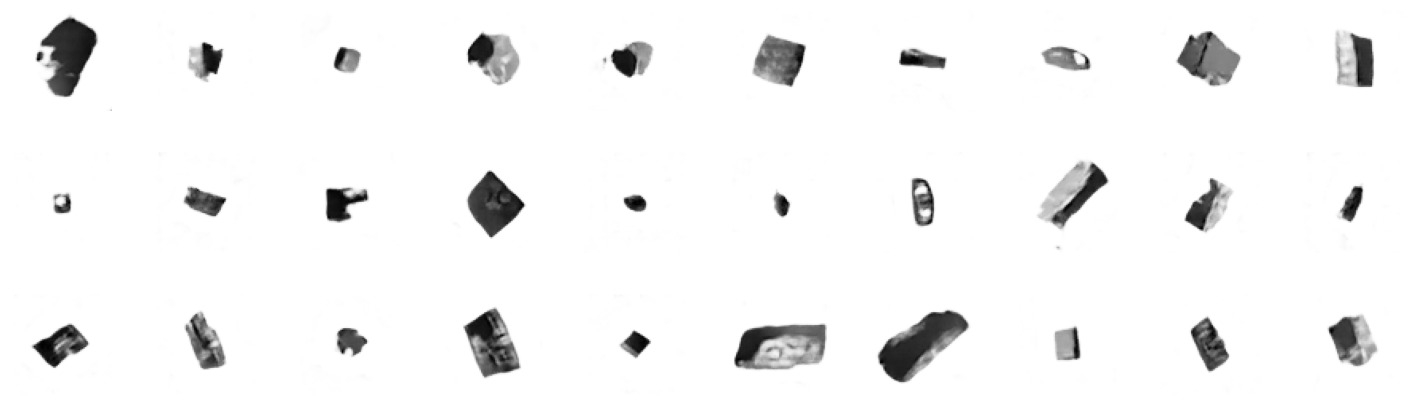

In [21]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :].permute(1, 2, 0), cmap="Greys")

In [22]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [23]:
all_data = []
for i, data in enumerate(trainloader, 0):
    all_data.extend(data[0].numpy())

all_data = np.array(all_data)

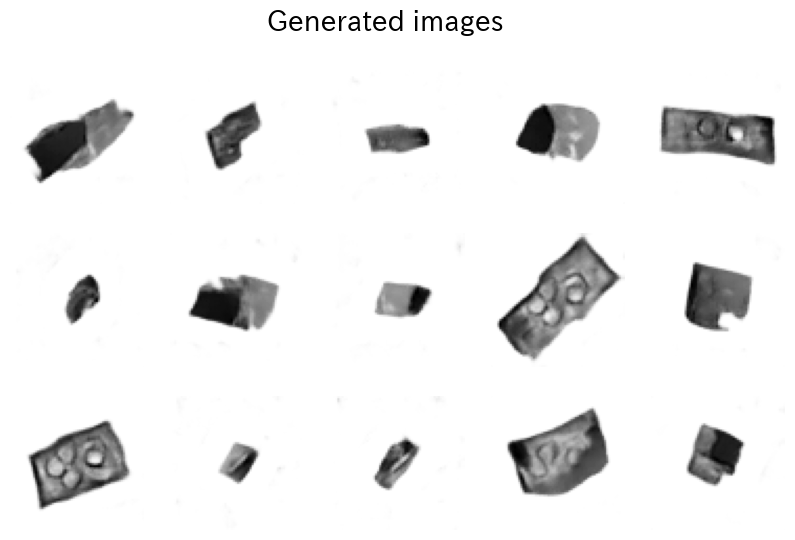

In [24]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs  = dcgan.G(torch.tensor(noise).float())

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt].detach().permute(1, 2, 0), cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

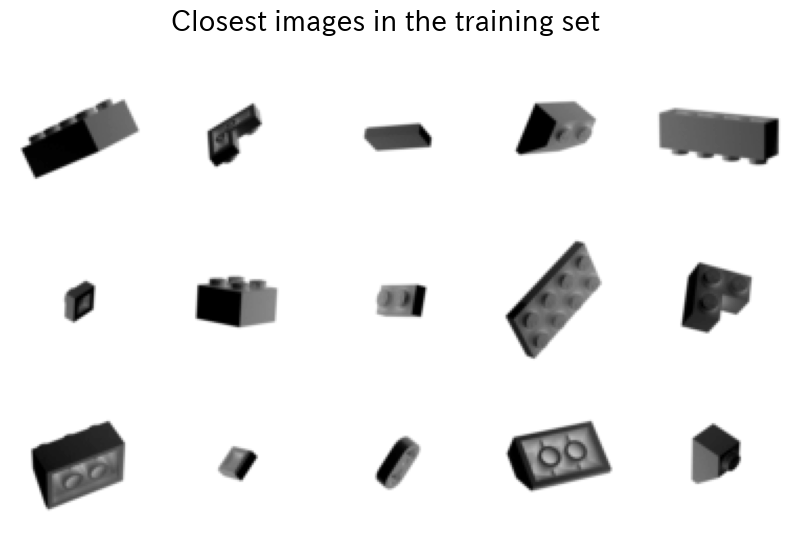

In [25]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt].detach().numpy(), k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img.transpose(1, 2, 0), cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=458d561e-694b-46db-9401-3185ba610507' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>